### SWT-MRA(1D)를 input으로 넣고 1D를 output으로 출력하는 모델 -> MRA level을 feature로 봄
#### Contaminated, Clean Scale을 다르게 함. (각자 scaling)

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_absolute_error, mean_squared_error

import pywt

import sys
sys.path.append('../../../tool_code/python_tool_code/function/') # "~~/tool_code/plot/" (상대 경로)
from DataPlot import Data_Load_Plot, Result_Plot, Loss_Plot

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Contaminated_data.shape: (10000, 4000)
Clean_data.shape: (10000, 4000)


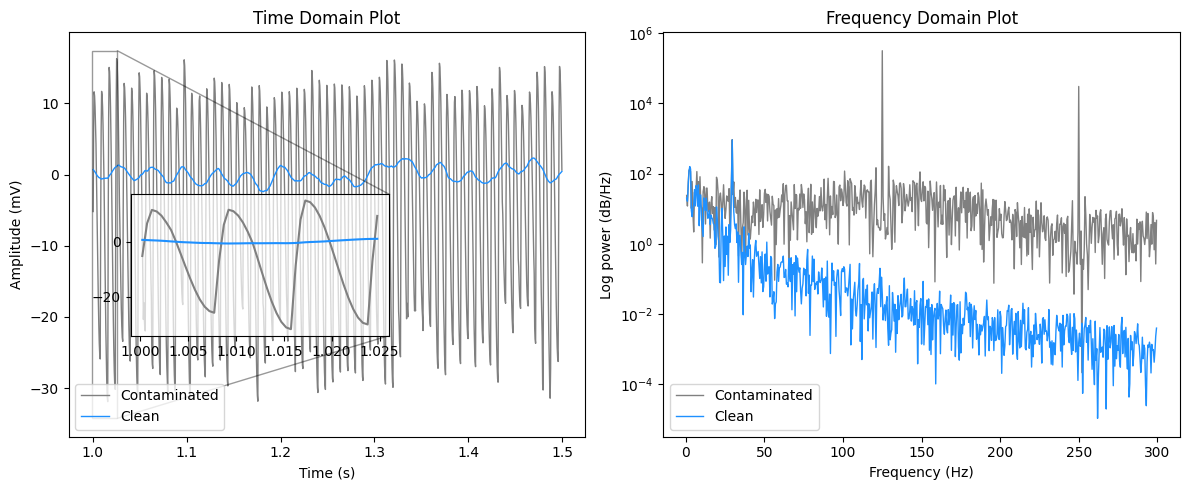

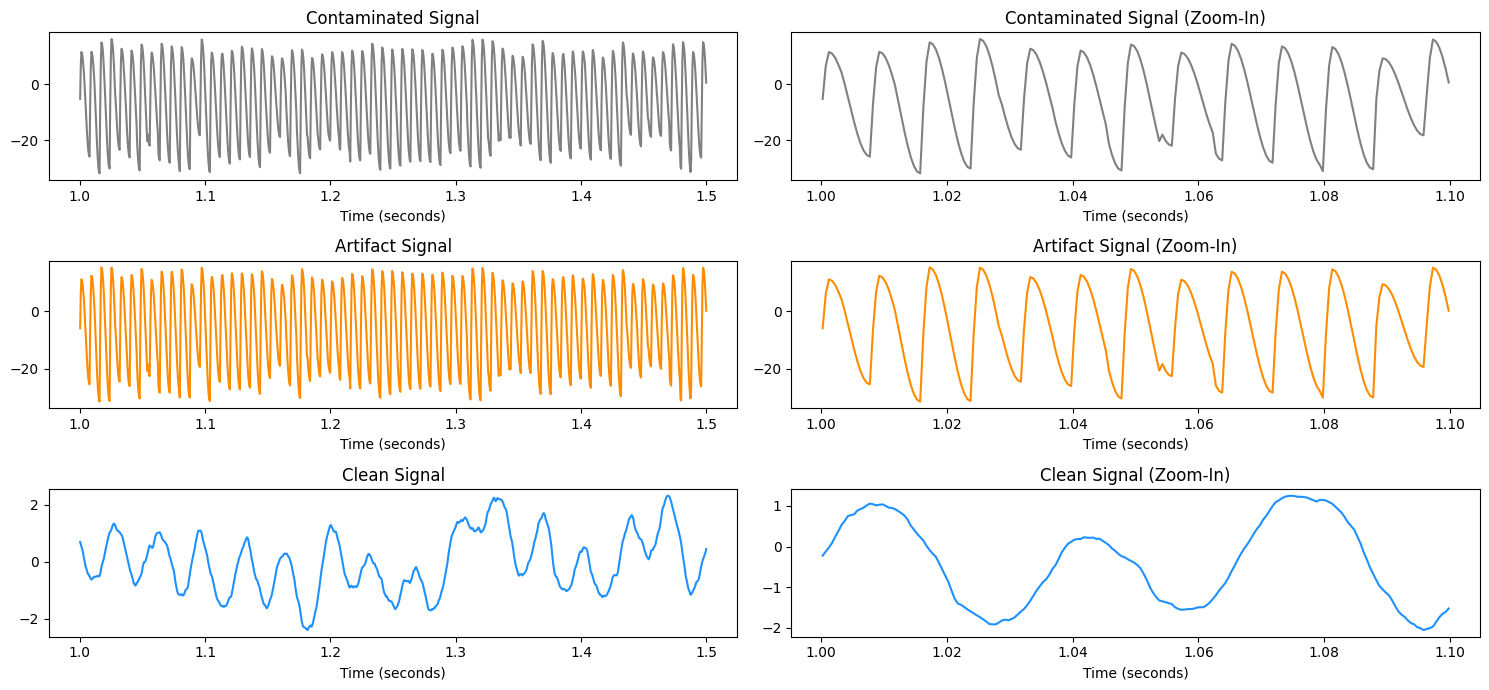

In [2]:
# 데이터 load & plot
datapath="C:/Users/stell/OneDrive/바탕 화면/paper_data/"

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

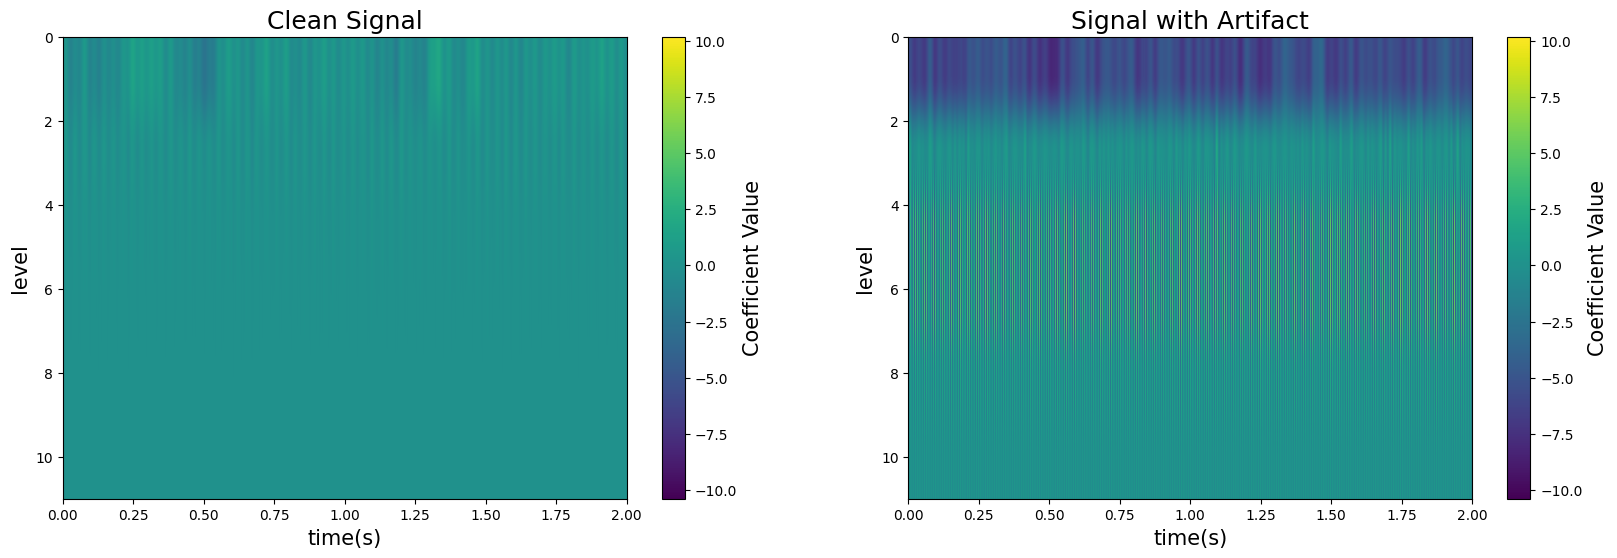

In [3]:
# SWT 수행 (MRA)
wavelet = 'db1'
mra_sig = pywt.mra(Clean_data[0], wavelet, transform='swt')
mra_art = pywt.mra(Contaminated_data[0], wavelet, transform='swt')

mra_sig = np.array(mra_sig)
mra_art = np.array(mra_art)

vmin, vmax = min(mra_sig.min(), mra_art.min()), max(mra_sig.max(), mra_art.max())

t = np.linspace(0, 2, num=4000)

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.imshow(mra_sig, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=[t[0], t[-1], 11, 0])
plt.colorbar().set_label('Coefficient Value', fontsize=15)
plt.xlabel('time(s)', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('Clean Signal', fontsize=18)

plt.subplot(1, 2, 2)
plt.imshow(mra_art, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=[t[0], t[-1], 11, 0])
plt.colorbar().set_label('Coefficient Value', fontsize=15)
plt.xlabel('time(s)', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('Signal with Artifact', fontsize=18)

plt.show()

In [4]:
X_wt = []
y_wt = []

wavelet = 'db1'

for x, y in zip(Contaminated_data, Clean_data):
    mra_x = pywt.mra(x, wavelet, transform='swt')
    mra_y = pywt.mra(y, wavelet, transform='swt')
    X_wt.append(mra_x)
    y_wt.append(mra_y)

X_wt = np.array(X_wt)
y_wt = np.array(y_wt)

print("X_wt:", X_wt.shape)
print("y_wt:", y_wt.shape)

X_wt: (10000, 6, 4000)
y_wt: (10000, 6, 4000)


In [5]:
# MRA 결과 scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X = []
y = [] 

scaler_x.fit(X_wt[0].flatten().reshape(-1, 1))
scaler_y.fit(y_wt[0].flatten().reshape(-1, 1))

for xx, yy in zip(X_wt, y_wt):
    flat_x = xx.flatten().reshape(-1, 1)
    flat_y = yy.flatten().reshape(-1, 1)
    scaled_flat_x = scaler_x.transform(flat_x)
    scaled_flat_y = scaler_y.transform(flat_y) # X, y 각자 scaling
    X.append(scaled_flat_x.reshape(xx.shape))
    y.append(scaled_flat_y.reshape(yy.shape))

X = np.transpose(np.array(X), (0, 2, 1))
y = np.transpose(np.array(y), (0, 2, 1))

print("X:", X.shape)
print("y:", y.shape)

X: (10000, 4000, 6)
y: (10000, 4000, 6)


In [6]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("<Data Shape>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

<Data Shape>
-----------------------------
X_train shape: (8000, 4000, 6)
y_train shape: (8000, 4000, 6)
-----------------------------
X_test shape: (2000, 4000, 6)
y_test shape: (2000, 4000, 6)
-----------------------------


In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define a fully connected layer that outputs the same size as the input features
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # Initialize hidden state with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # Initialize cell state with zeros
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of all time steps
        out = self.fc(out)
        return out

In [8]:
# Example usage
input_size = 6  # Number of features
hidden_size = 128
num_layers = 2
output_size = 6  # Same as the number of input features for regression

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

LSTMModel(
  (lstm): LSTM(6, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)


In [9]:
# 모델 학습
num_epochs = 500

train_list = []
test_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)

    # model.eval()
    # test_loss = 0.0
    # with torch.no_grad():
    #     for x, y in test_loader:
    #         x, y = x.to(device), y.to(device)
    #         y_pred = model(x)
    #         loss = criterion(y_pred, y)
    #         test_loss += loss.item() * x.size(0)
    # test_loss /= len(test_loader.dataset)

    train_list.append(epoch_loss)
    # test_list.append(test_loss)
    if (epoch+1)%1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss}')

Epoch [1/500] | Loss: 0.2953526041805744
Epoch [2/500] | Loss: 0.10735252666473388
Epoch [3/500] | Loss: 0.08564506441354752
Epoch [4/500] | Loss: 0.07261274732649327
Epoch [5/500] | Loss: 0.06214421135187149
Epoch [6/500] | Loss: 0.057326512068510055
Epoch [7/500] | Loss: 0.0515084450095892
Epoch [8/500] | Loss: 0.04757720696926117
Epoch [9/500] | Loss: 0.04483901080489159
Epoch [10/500] | Loss: 0.06174715808033943
Epoch [11/500] | Loss: 0.05435229851305485
Epoch [12/500] | Loss: 0.0435854647308588
Epoch [13/500] | Loss: 0.05800215777754784
Epoch [14/500] | Loss: 0.04543147720396519
Epoch [15/500] | Loss: 0.04512719257175923
Epoch [16/500] | Loss: 0.04142054884135723
Epoch [17/500] | Loss: 0.04118861939013004
Epoch [18/500] | Loss: 0.03933566620200873
Epoch [19/500] | Loss: 0.0371605062186718
Epoch [20/500] | Loss: 0.04759996343404055
Epoch [21/500] | Loss: 0.05613487637042999
Epoch [22/500] | Loss: 0.04177398818731308
Epoch [23/500] | Loss: 0.03966231732070446
Epoch [24/500] | Loss: 

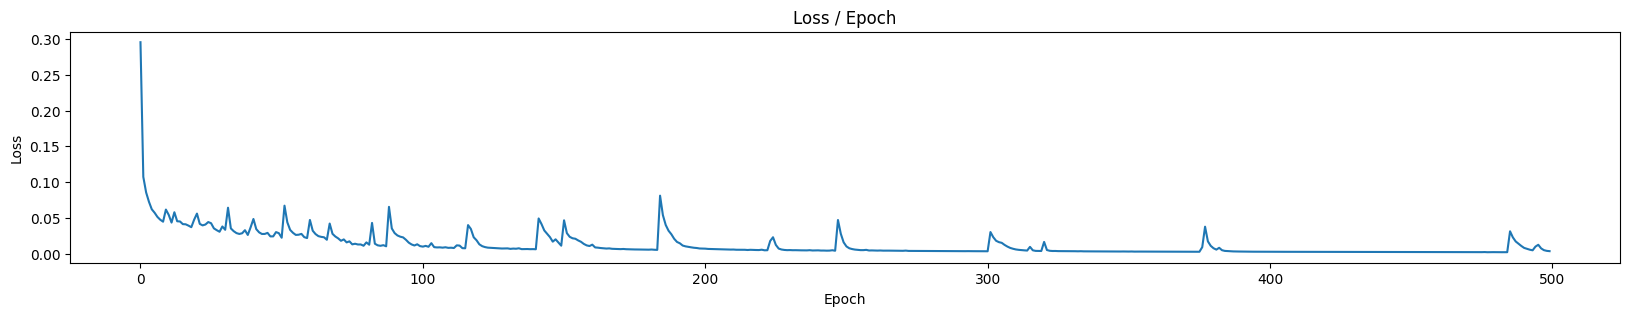

Minimal Loss: 0.002209236859343946 [477]



In [10]:
Loss_Plot(train_list)
# Loss_Plot(test_list)

In [11]:
# 모델 파라미터 저장
torch.save(model.state_dict(), '../model_saved/LSTM_IO_MRA_1D_swt_10000.pth')

In [12]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])

model.eval()
test_loss = 0.0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x)
        loss = criterion(y_pred, y)
        test_loss += loss.item() * x.size(0)

        Contaminated = torch.cat((Contaminated, x.permute(0, 2, 1).cpu()), 0)
        SACed = torch.cat((SACed, y_pred.permute(0, 2, 1).cpu()), 0)
        Clean = torch.cat((Clean, y.permute(0, 2, 1).cpu()), 0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0037


Mean Absolute Error: 0.042128708213567734
Mean Squared Error: 0.0035038944333791733


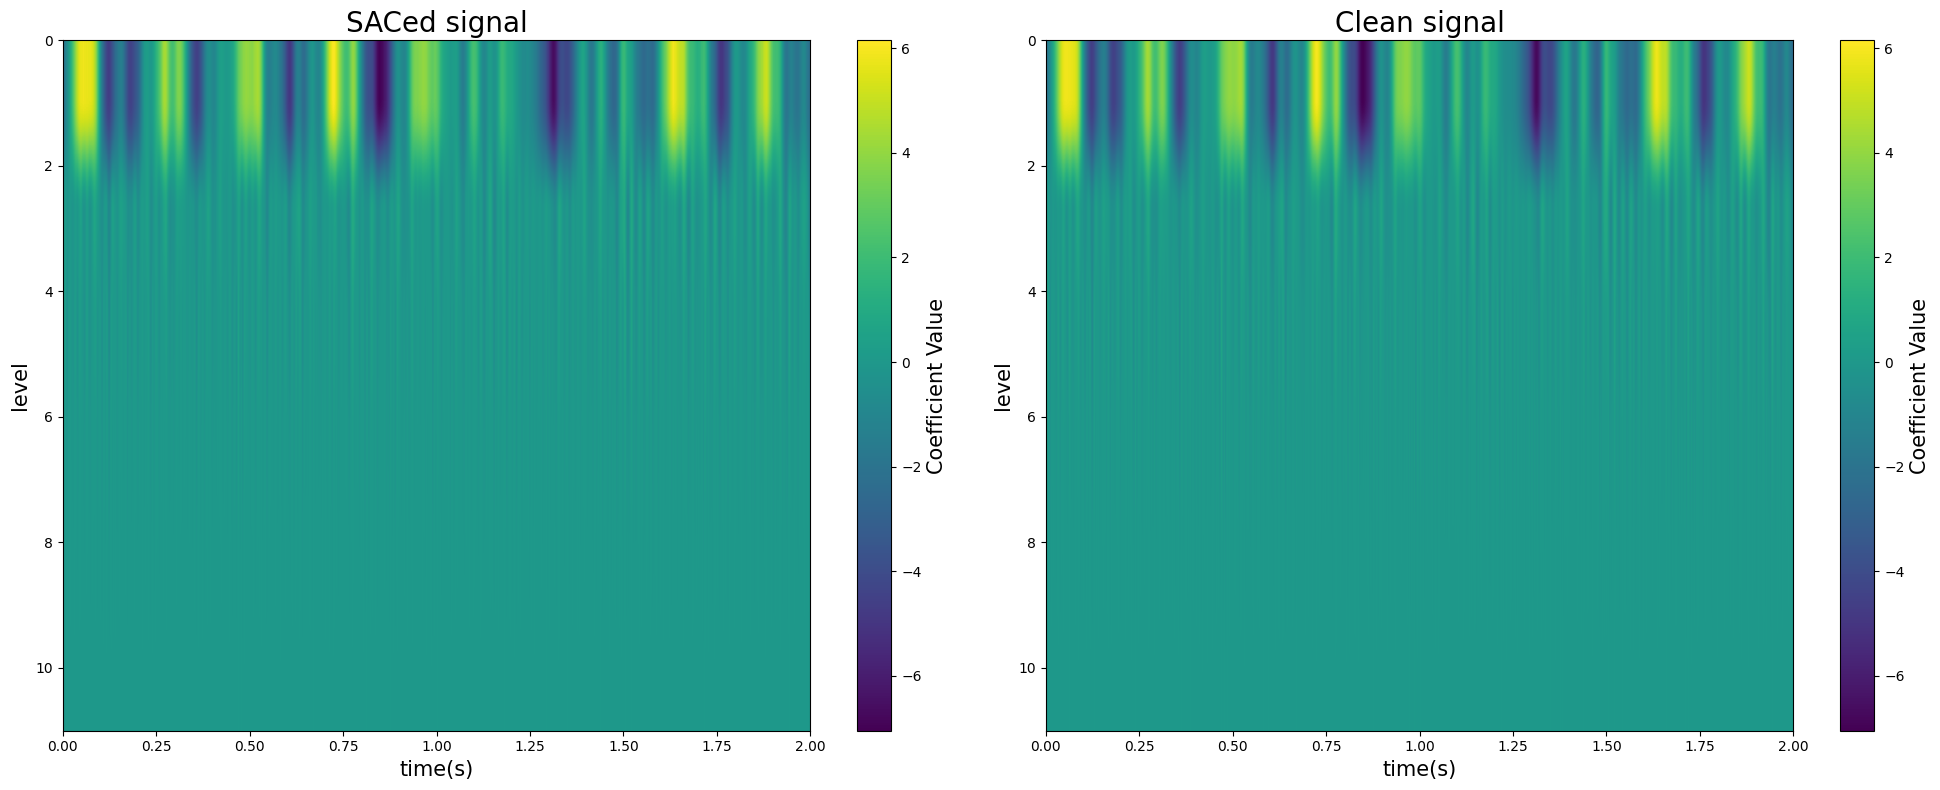

In [13]:
# MRA Plot
SACed_ex = SACed[0].detach().cpu()
Clean_ex = Clean[0].detach().cpu()

vmin, vmax = min(SACed_ex.min(), Clean_ex.min()), max(SACed_ex.max(), Clean_ex.max())

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(SACed_ex, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=[t[0], t[-1], 11, 0])
plt.colorbar().set_label('Coefficient Value', fontsize=15)
plt.xlabel('time(s)', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('SACed signal', fontsize=20)

plt.subplot(1, 2, 2)
plt.imshow(Clean_ex, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=[t[0], t[-1], 11, 0])
plt.colorbar().set_label('Coefficient Value', fontsize=15)
plt.xlabel('time(s)', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('Clean signal', fontsize=20)

plt.tight_layout()

print(f"Mean Absolute Error: {mean_absolute_error(Clean_ex, SACed_ex)}")
print(f"Mean Squared Error: {mean_squared_error(Clean_ex, SACed_ex)}")

In [14]:
# MRA 결과 inverse scaling
Contaminated_inverse_scaled = []
SACed_inverse_scaled = []
Clean_inverse_scaled = []

for xx, yhat, yy in zip(Contaminated, SACed, Clean):
    flat_x = xx.flatten().reshape(-1, 1)
    flat_yhat = yhat.flatten().reshape(-1, 1)
    flat_y = yy.flatten().reshape(-1, 1)

    inv_flat_x = scaler_x.inverse_transform(flat_x)
    inv_flat_yhat = scaler_y.inverse_transform(flat_yhat)
    inv_flat_y = scaler_y.inverse_transform(flat_y)

    Contaminated_inverse_scaled.append(inv_flat_x.reshape(xx.shape))
    SACed_inverse_scaled.append(inv_flat_yhat.reshape(yhat.shape))
    Clean_inverse_scaled.append(inv_flat_y.reshape(yy.shape))

Contaminated_inverse_scaled = np.array(Contaminated_inverse_scaled)
SACed_inverse_scaled = np.array(SACed_inverse_scaled)
Clean_inverse_scaled = np.array(Clean_inverse_scaled)


# MRA 데이터를 inverse하여 시계열 데이터로 변환

Contaminated_invdwt = []
SACed_invdwt = []
Clean_invdwt = []

for mra_x, mra_yhat, mra_y in zip(Contaminated_inverse_scaled, SACed_inverse_scaled, Clean_inverse_scaled):
    contaminated_invdwt = pywt.imra(mra_x)
    saced_invdwt = pywt.imra(mra_yhat)
    clean_invdwt = pywt.imra(mra_y)
    
    Contaminated_invdwt.append(contaminated_invdwt)
    SACed_invdwt.append(saced_invdwt)
    Clean_invdwt.append(clean_invdwt)

Contaminated_invdft = np.array(Contaminated_invdwt)
SACed_invdft = np.array(SACed_invdwt)
Clean_invdft = np.array(Clean_invdwt)

print("X_reconstructed:", Contaminated_invdft.shape)
print("yhat_reconstructed:", SACed_invdft.shape)
print("y_reconstructed:", Clean_invdft.shape)

X_reconstructed: (2000, 4000)
yhat_reconstructed: (2000, 4000)
y_reconstructed: (2000, 4000)


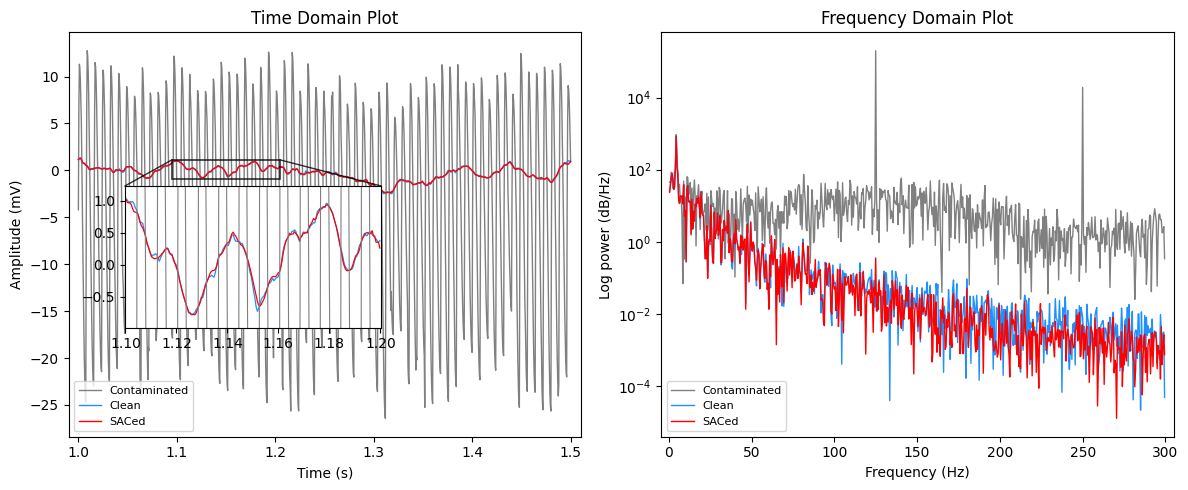

< MSE >
Time Domain MSE: 0.003932612737929599 ± 0.0014928485109254334
Frequency Domain MSE: 0.1313695503427789 ± 0.118877204829274
Time + Frequency MSE: 0.6593632261667487 ± 0.24440699790545042


In [15]:
# 결과 Plot
from DataPlot import Data_Load_Plot, Result_Plot_paper, Loss_Plot

save_path = '../../../result/data_10000/LSTM/'
save_title = 'LSTM_IO_MRA_1D_swt'

Result_Plot(Contaminated_invdft, SACed_invdft, Clean_invdft, save_path, save_title) # inverse scaled data를 input으로 넣음
# Result_Plot_paper(Contaminated_invdft, SACed_invdft, Clean_invdft, save_path, save_title) # inverse scaled data를 input으로 넣음
